# Currency Arbitrage

This strategy will look for arbitrage opportunities in currency prices by constructing a graph with edge weights based on the currency exchange rates and then finding the cycles in the graph that yield positive returns.

## Initialization

In [1]:
# initialize the module and import all libraries
from init import *

## Config

In [2]:
START_DATE = "2023-01-01"
END_DATE = "2024-01-01"
INTERVAL = "1d"

TEST_DATE = "2023-01-04"

CURRENCIES = ["USD", "EUR", "JPY", "GBP", "AUD", "NZD", "HKD"]

MAX_ARB_LENGTH = None

## Data Collection and Preparation

In [3]:
# currency pairs
pairs = [(c1, c2) for c1 in CURRENCIES for c2 in CURRENCIES if c1 != c2]

# tickers
tickers = list(map(lambda p : f"{p[0]}{p[1]}=X", pairs))

# new column names
columns = list(map(lambda p : f"{p[0]}->{p[1]}", pairs))

# mapping
ticker_to_column = {ticker:column for ticker, column in zip(tickers, columns)}

In [4]:
prices_df = yf.download(tickers=tickers, start=START_DATE, end=END_DATE, interval=INTERVAL)["Adj Close"]
prices_df.columns = [ticker_to_column[ticker] for ticker in prices_df.columns]
prices_df.head()

[*********************100%%**********************]  42 of 42 completed


,AUD->EUR,AUD->GBP,AUD->HKD,AUD->JPY,AUD->NZD,AUD->USD,EUR->AUD,EUR->GBP,EUR->HKD,EUR->JPY,...,NZD->GBP,NZD->HKD,NZD->JPY,NZD->USD,USD->AUD,USD->EUR,USD->GBP,USD->HKD,USD->JPY,USD->NZD
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-02,0.63644,0.56307,5.317602,89.194000,1.069761,0.682310,1.56860,0.88414,8.34821,140.309998,...,0.52195,4.954427,83.044998,0.637480,1.465610,0.93373,0.82506,7.79925,130.845001,1.568677
2023-01-03,0.63710,0.56390,5.310630,89.009003,1.075770,0.680560,1.56888,0.88511,8.33260,139.649002,...,0.52430,4.936535,82.723000,0.632639,1.469378,0.93653,0.82899,7.80550,130.794006,1.580680
2023-01-04,0.63763,0.56183,5.254005,88.264000,1.076570,0.672800,1.56804,0.88089,8.23920,138.408997,...,0.52178,4.880089,81.973999,0.624711,1.486326,0.94815,0.83544,7.81320,131.248001,1.600740
2023-01-05,0.64370,0.56633,5.336870,90.308998,1.086496,0.682911,1.55303,0.87947,8.28960,140.253998,...,0.52115,4.911701,83.097000,0.628512,1.464320,0.94283,0.82939,7.81571,132.246002,1.591060
2023-01-06,0.64199,0.56707,5.276832,90.054001,1.083300,0.675570,1.55749,0.88324,8.21885,140.259995,...,0.52294,4.866738,83.042999,0.623080,1.480232,0.95037,0.83947,7.81150,133.307007,1.604930


## Research

In [8]:
def create_graph(date):
    G = nx.DiGraph()

    G.add_nodes_from(CURRENCIES)
    attributes = {
        pair: {
            "weight": -np.log2(prices_df.loc[date, column_name]),
            "exchange_rate": prices_df.loc[date, column_name],
            "column_name": column_name,
        }
        for pair, column_name in zip(pairs, columns)
    }
    G.add_edges_from(pairs)
    nx.set_edge_attributes(G=G, values=attributes)

    return G

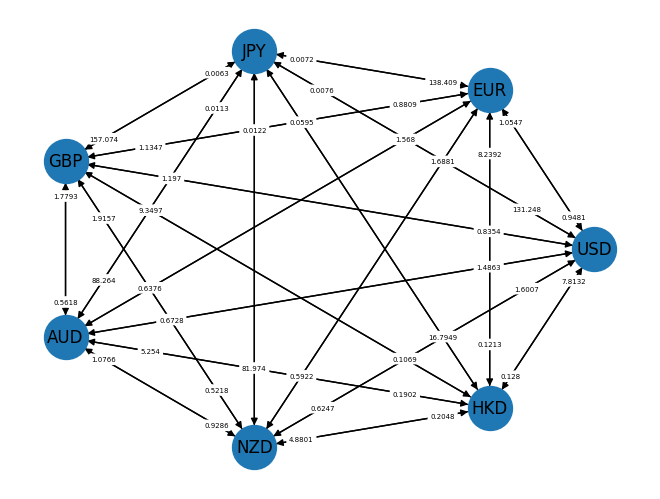

In [9]:
G = create_graph(TEST_DATE)
pos = nx.circular_layout(G)
nx.draw(G=G, pos=pos, with_labels=True, node_size=1000)
exchange_rates = {
    k: np.round(v, 4) for k, v in nx.get_edge_attributes(G, "exchange_rate").items()
}
_ = nx.draw_networkx_edge_labels(
    G=G, pos=pos, edge_labels=exchange_rates, label_pos=0.8, rotate=False, font_size=5
)

In [10]:
def find_path_arbitrage_returns(G):
    max_returns, path = 1.0, []
    exchange_rates = nx.get_edge_attributes(G, "exchange_rate")
    for cycle in nx.simple_cycles(G=G, length_bound=MAX_ARB_LENGTH):
        returns = 1
        cycle.append(cycle[0])
        for pair in zip(cycle[:-1], cycle[1:]):
            returns *= exchange_rates[pair]
        if returns > max_returns:
            max_returns = returns
            path = cycle
    return max_returns, path

In [11]:
find_path_arbitrage_returns(G)

(1.0002766428793783, ['EUR', 'AUD', 'USD', 'EUR'])

## Strategy

In [12]:
trades_df = pd.DataFrame(index=prices_df.index)
trades_df["daily_returns"] = 1.0
trades_df["trades"] = ""
for date in prices_df.index:
    graph = create_graph(date)
    returns, path = find_path_arbitrage_returns(graph)
    trades_df.loc[date, "daily_returns"] = returns
    trades_df.loc[date, "trades"] = "->".join(path)
trades_df["cum_returns"] = trades_df["daily_returns"].cumprod()
trades_df.head()

,daily_returns,trades,cum_returns
Date,,,
2023-01-02,1.002053,EUR->NZD->USD->EUR,1.002053
2023-01-03,1.000021,AUD->NZD->USD->AUD,1.002074
2023-01-04,1.000277,EUR->AUD->USD->EUR,1.002351
2023-01-05,1.000008,EUR->NZD->USD->EUR,1.002359
2023-01-06,1.000000,GBP->USD->GBP,1.002359


## Performance

In [13]:
final_returns = trades_df["cum_returns"].iloc[-1]
years = (
    pd.Timestamp(END_DATE) - pd.Timestamp(START_DATE)
).to_timedelta64() / pd.Timedelta(days=365)

print(f"Final Returns: {np.round(100 * final_returns - 1, 3)}%")
print(f"Annual Returns: {np.round(100 * final_returns ** (1 / years) - 1, 3)}%")
print(f"Years: {years}")

Final Returns: 103.478%
Annual Returns: 103.478%
Years: 1.0


In [14]:
plot_df = pd.DataFrame(index=pd.date_range(START_DATE, END_DATE))
plot_df["cum_returns"] = trades_df["cum_returns"]
plot_df = plot_df.ffill().bfill()

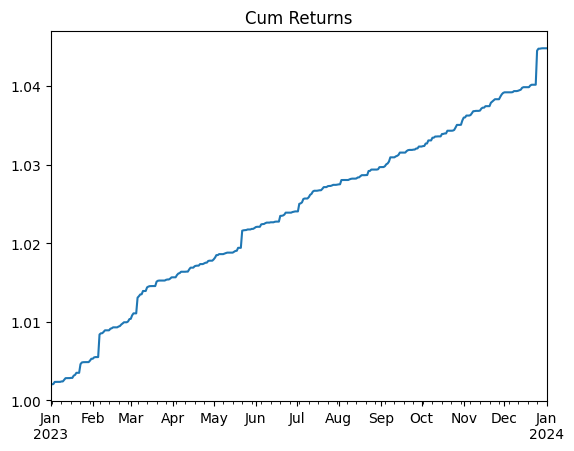

In [15]:
plot_df["cum_returns"].plot()
plt.title("Cum Returns")
plt.show()

In [16]:
most_profitable_day = trades_df.index[trades_df["daily_returns"].argmax()]
most_profitable_day

Timestamp('2023-12-25 00:00:00')

In [17]:
trades_df.loc[most_profitable_day]

daily_returns                        1.004165
trades           GBP->JPY->EUR->NZD->USD->GBP
cum_returns                           1.04448
Name: 2023-12-25 00:00:00, dtype: object

In [18]:
prices_on_day = prices_df.loc[most_profitable_day]
path = trades_df.loc[most_profitable_day]["trades"].split("->")
conversions = []
for pair in zip(path[:-1], path[1:]):
    column_name = "->".join(pair)
    print(column_name, prices_on_day[column_name])
    conversions.append(prices_on_day[column_name])
print(np.prod(conversions))

GBP->JPY 181.17361450195312
JPY->EUR 0.006364000029861927
EUR->NZD 1.7471400499343872
NZD->USD 0.6319299340248108
USD->GBP 0.7888299822807312
1.00416522701453


## Testing

In [19]:
df_test = yf.download(
    ["EURUSD=X", "USDEUR=X"], start=START_DATE, end=END_DATE, interval="1d"
)["Adj Close"]
df_test.head()

[*********************100%%**********************]  2 of 2 completed


,EURUSD=X,USDEUR=X
Date,,
2023-01-02,1.070973,0.93373
2023-01-03,1.067771,0.93653
2023-01-04,1.054685,0.94815
2023-01-05,1.060637,0.94283
2023-01-06,1.052222,0.95037


In [20]:
df_test.loc[TEST_DATE, "EURUSD=X"]

1.0546854734420776

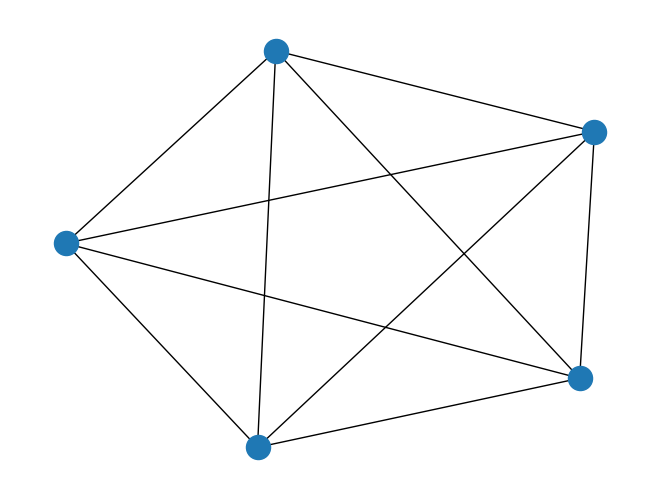

In [21]:
temp_G = nx.complete_graph(5)
nx.draw(temp_G)

In [22]:
(pd.Timestamp(END_DATE) - pd.Timestamp(START_DATE)).to_timedelta64() / pd.Timedelta(
    days=365
)

1.0